Load Dataset of 20 classes from cifar 100

In [ ]:
import tensorflow as tf
from keras.datasets import cifar100
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model



In [ ]:

def display_img(img_set, title_set):
    n = len(title_set)
    for i in range(n):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_set[i])
        plt.title(title_set[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
trainX.shape: (50000, 32, 32, 3), trainY.shape: (50000, 1), testX.shape: (10000, 32, 32, 3), testY.shape: (10000, 1)
trainX.dtype: uint8, trainY.dtype: int64, testX.dtype: uint8, testY.dtype: int64
trainX.Range: 255 - 0, testX.Range: 255 - 0


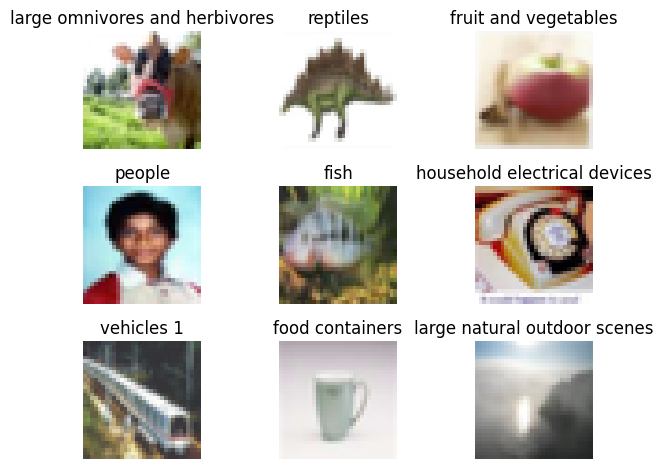

In [ ]:
(trainX, trainY), (testX, testY) = cifar100.load_data(label_mode='coarse')

print('trainX.shape: {}, trainY.shape: {}, testX.shape: {}, testY.shape: {}'.format(trainX.shape, trainY.shape, testX.shape, testY.shape))
print('trainX.dtype: {}, trainY.dtype: {}, testX.dtype: {}, testY.dtype: {}'.format(trainX.dtype, trainY.dtype, testX.dtype, testY.dtype))
print('trainX.Range: {} - {}, testX.Range: {} - {}'.format(trainX.max(), trainX.min(), testX.max(), testX.min()))

coarse_label_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles',
    'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

display_img(trainX[:9], [coarse_label_names[label[0]] for label in trainY[:9]])

Pre-Process the data

In [ ]:
# Normalize the pixel values to [0, 1]
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Resize images to 96x96 (required by most ImageNet pre-trained models)
trainX = tf.image.resize(trainX, (96, 96))
testX = tf.image.resize(testX, (96, 96))

# Convert labels to one-hot encoding (20 classes)
trainY = to_categorical(trainY, num_classes=20)
testY = to_categorical(testY, num_classes=20)

# Print data shapes and types
print(f"trainX.shape: {trainX.shape}, testX.shape: {testX.shape}")
print(f"trainX.dtype: {trainX.dtype}, testX.dtype: {testX.dtype}")
print(f"trainY.shape: {trainY.shape}, testY.shape: {testY.shape}")
print(f"trainY.dtype: {trainY.dtype}, testY.dtype: {testY.dtype}")

# Check sample labels
print("Sample trainY (one-hot encoded):")
print(trainY[:5])

trainX.shape: (50000, 96, 96, 3), testX.shape: (10000, 96, 96, 3)
trainX.dtype: <dtype: 'float32'>, testX.dtype: <dtype: 'float32'>
trainY.shape: (50000, 20), testY.shape: (10000, 20)
trainY.dtype: float64, testY.dtype: float64
Sample trainY (one-hot encoded):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


1. MobileNet

In [ ]:
mobilenet = MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze all layers in the MobileNet backbone
for layer in mobilenet.layers:
    layer.trainable = False

<ipython-input-7-e727bf1634fb>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs_mobilenet = mobilenet.input
x = mobilenet.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs_final = Dense(20, activation='softmax', name='OutputLayer')(x)

# Create the model
model = Model(inputs=inputs_mobilenet, outputs=outputs_final, name='MobileNet_CIFAR100_20Classes')

# Print model summary
model.summary()

Model: "MobileNet_CIFAR100_20Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 48, 48, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 24, 24, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 24, 24, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 24, 24, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 24, 24, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,819,668 (18.39 MB)

 Trainable params: 1,587,732 (6.06 MB)

 Non-trainable params: 3,231,936 (12.33 MB)

Transfer Learning

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_transfer_learning = model.fit(trainX, trainY, batch_size=64, validation_split=0.1, epochs=10, verbose=1)

t_loss, t_acc = model.evaluate(testX, testY, verbose=0)
print(f"📊 Transfer Learning Test Accuracy: {t_acc:.4f}")

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.4746 - loss: 1.9103 - val_accuracy: 0.6626 - val_loss: 1.0305
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6422 - loss: 1.1255 - val_accuracy: 0.6810 - val_loss: 0.9734
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6784 - loss: 1.0068 - val_accuracy: 0.6892 - val_loss: 0.9497
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6936 - loss: 0.9397 - val_accuracy: 0.6960 - val_loss: 0.9432
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7131 - loss: 0.8782 - val_accuracy: 0.7014 - val_loss: 0.9329
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7302 - loss: 0.8237 - val_accuracy: 0.7044 - val_loss: 0.9179
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7420 - loss: 0.7957 - val_accuracy: 0.7146 - val_loss: 0.9104
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7514 - loss: 0.7494 - 

Finetuning the model

In [ ]:
#  Unfreeze the last 40 layers of MobileNet for fine-tuning
for layer in model.layers[-40:]:
    layer.trainable = True

#  Compile the model with a low learning rate (crucial for fine-tuning)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Fine-tune the model (on 90% train, 10% validation)
history_finetune = model.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    verbose=1
)

#  Evaluate the model on the test set
finetune_loss, finetune_accuracy = model.evaluate(testX, testY, verbose=0)
print(f"📊 Fine-Tuning Test Accuracy: {finetune_accuracy:.4f}")

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.6291 - loss: 1.2300 - val_accuracy: 0.6934 - val_loss: 0.9979
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7659 - loss: 0.7337 - val_accuracy: 0.7146 - val_loss: 0.9373
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7963 - loss: 0.6344 - val_accuracy: 0.7640 - val_loss: 0.7436
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8573 - loss: 0.4425 - val_accuracy: 0.7604 - val_loss: 0.7877
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8810 - loss: 0.3687 - val_accuracy: 0.7558 - val_loss: 0.8744
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8966 - loss: 0.3216 - val_accuracy: 0.7044 - val_loss: 1.2066
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9173 - loss: 0.2593 - val_accuracy: 0.7572 - val_loss: 0.9184
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9202 - loss: 0.2443 - 

2. VGG 16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [ ]:
vgg_base = VGG16(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze all layers in VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classification head
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='softmax', name='OutputLayer')(x)

# Final model
model_vgg16 = Model(inputs=vgg_base.input, outputs=outputs, name='VGG16_CIFAR100_20Classes')
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_CIFAR100_20Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,80

 Total params: 15,781,204 (60.20 MB)

 Trainable params: 1,063,444 (4.06 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [ ]:
# Compile the model for transfer learning
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train only the new head
history_vgg_transfer = model_vgg16.fit(
    trainX, trainY,
    batch_size=64,
    validation_split=0.1,
    epochs=10,
    verbose=1
)

# Evaluate
vgg_transfer_loss, vgg_transfer_acc = model_vgg16.evaluate(testX, testY, verbose=0)
print(f"📊 VGG16 Transfer Learning Test Accuracy: {vgg_transfer_acc:.4f}")

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 95ms/step - accuracy: 0.3076 - loss: 2.5688 - val_accuracy: 0.4804 - val_loss: 1.6405
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 88ms/step - accuracy: 0.4436 - loss: 1.7746 - val_accuracy: 0.5102 - val_loss: 1.5596
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.4774 - loss: 1.6511 - val_accuracy: 0.5054 - val_loss: 1.5693
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.4903 - loss: 1.6042 - val_accuracy: 0.5162 - val_loss: 1.5204
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.4972 - loss: 1.5733 - val_accuracy: 0.5284 - val_loss: 1.4730
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.5054 - loss: 1.5505 - val_accuracy: 0.5170 - val_loss: 1.5057
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.5103 - loss: 1.5245 - val_accuracy: 0.5196 - val_loss: 1.4949
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.5170 - loss: 1.5073 - 

In [ ]:
# Unfreeze last few layers of VGG16 (e.g., last 4 conv blocks)
for layer in model_vgg16.layers[-40:]:
    layer.trainable = True

# Recompile with lower learning rate
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_vgg_finetune = model_vgg16.fit(
    trainX, trainY,
    batch_size=64,
    validation_split=0.1,
    epochs=10,
    verbose=1
)

# Evaluate fine-tuned model
vgg_finetune_loss, vgg_finetune_acc = model_vgg16.evaluate(testX, testY, verbose=0)
print(f"📊 VGG16 Fine-Tuning Test Accuracy: {vgg_finetune_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 171s 211ms/step - accuracy: 0.1040 - loss: 3.0172 - val_accuracy: 0.0598 - val_loss: 9.5246
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 181s 206ms/step - accuracy: 0.1358 - loss: 2.7301 - val_accuracy: 0.0582 - val_loss: 9.3090
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 206ms/step - accuracy: 0.1618 - loss: 2.6361 - val_accuracy: 0.0886 - val_loss: 4.2988
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 197s 199ms/step - accuracy: 0.1712 - loss: 2.5762 - val_accuracy: 0.0740 - val_loss: 3.9215
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 144s 205ms/step - accuracy: 0.2134 - loss: 2.4433 - val_accuracy: 0.1784 - val_loss: 2.6838
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 205ms/step - accuracy: 0.2629 - loss: 2.3002 - val_accuracy: 0.0982 - val_loss: 4.2046
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 205ms/step - accuracy: 0.2966 - loss: 2.1681 - val_accuracy: 0.2832 - val_loss: 2.3082
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 197s 198ms/step - accuracy: 0.3301 -

3. ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [ ]:
resnet_base = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze base model
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='softmax')(x)

model_resnet = Model(inputs=resnet_base.input, outputs=outputs, name='ResNet50_CIFAR100_20')
model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_CIFAR100_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 26,227,092 (100.05 MB)

 Trainable params: 2,636,308 (10.06 MB)

 Non-trainable params: 23,590,784 (89.99 MB)

In [ ]:
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet_transfer = model_resnet.fit(trainX, trainY, batch_size=64,
                                           validation_split=0.1, epochs=10, verbose=1)

resnet_transfer_loss, resnet_transfer_acc = model_resnet.evaluate(testX, testY, verbose=0)
print(f"📊 ResNet50 Transfer Learning Accuracy: {resnet_transfer_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.1327 - loss: 3.4003 - val_accuracy: 0.1454 - val_loss: 3.9079
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.2130 - loss: 2.6663 - val_accuracy: 0.0566 - val_loss: 8.7445
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.2366 - loss: 2.5024 - val_accuracy: 0.0688 - val_loss: 9.9889
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.2530 - loss: 2.4531 - val_accuracy: 0.1130 - val_loss: 4.1794
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.2595 - loss: 2.4307 - val_accuracy: 0.1440 - val_loss: 4.4494
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.2641 - loss: 2.3984 - val_accuracy: 0.0624 - val_loss: 15.9041
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.2707 - loss: 2.3806 - val_accuracy: 0.1140 - val_loss: 5.2075
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.2703 - loss: 2.3712 -

In [ ]:
for layer in model_resnet.layers[-40:]:
    layer.trainable = True

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet_finetune = model_resnet.fit(trainX, trainY, batch_size=64,
                                           validation_split=0.1, epochs=15, verbose=1)

resnet_finetune_loss, resnet_finetune_acc = model_resnet.evaluate(testX, testY, verbose=0)
print(f"📊 ResNet50 Fine-Tuning Accuracy: {resnet_finetune_acc:.4f}")


Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.2238 - loss: 2.5335 - val_accuracy: 0.0602 - val_loss: 19.1692
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.3113 - loss: 2.2225 - val_accuracy: 0.0700 - val_loss: 16.6538
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.3353 - loss: 2.1320 - val_accuracy: 0.0686 - val_loss: 19.6348
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.3593 - loss: 2.0767 - val_accuracy: 0.0544 - val_loss: 48.6148
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.3739 - loss: 2.0337 - val_accuracy: 0.0932 - val_loss: 22.2196
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 60ms/step - accuracy: 0.3756 - loss: 2.0141 - val_accuracy: 0.0548 - val_loss: 28.8193
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.3835 - loss: 1.9842 - val_accuracy: 0.0748 - val_loss: 16.1075
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.3869 - loss: 1.

4. InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

inception_base = InceptionV3(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

for layer in inception_base.layers:
    layer.trainable = False

x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='softmax')(x)

model_inception = Model(inputs=inception_base.input, outputs=outputs, name='InceptionV3_CIFAR100_20')
model_inception.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "InceptionV3_CIFAR100_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 24,442,164 (93.24 MB)

 Trainable params: 2,636,308 (10.06 MB)

 Non-trainable params: 21,805,856 (83.18 MB)

In [ ]:
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy', metrics=['accuracy'])

history_inception_transfer = model_inception.fit(trainX, trainY, batch_size=64,
                                                 validation_split=0.1, epochs=10, verbose=1)

inception_transfer_loss, inception_transfer_acc = model_inception.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionV3 Transfer Learning Accuracy: {inception_transfer_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.3292 - loss: 2.5423 - val_accuracy: 0.5080 - val_loss: 1.5845
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.4797 - loss: 1.6767 - val_accuracy: 0.5286 - val_loss: 1.5142
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5171 - loss: 1.5423 - val_accuracy: 0.5438 - val_loss: 1.4672
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5338 - loss: 1.4811 - val_accuracy: 0.5374 - val_loss: 1.4718
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5435 - loss: 1.4438 - val_accuracy: 0.5542 - val_loss: 1.4264
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5603 - loss: 1.3944 - val_accuracy: 0.5446 - val_loss: 1.4430
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5630 - loss: 1.3722 - val_accuracy: 0.5628 - val_loss: 1.4234
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5740 - loss: 1.3375 - 

In [ ]:
for layer in model_inception.layers[-40:]:
    layer.trainable = True

model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy', metrics=['accuracy'])

history_inception_finetune = model_inception.fit(trainX, trainY, batch_size=64,
                                                 validation_split=0.1, epochs=10, verbose=1)

inception_finetune_loss, inception_finetune_acc = model_inception.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionV3 Fine-Tuning Accuracy: {inception_finetune_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 57ms/step - accuracy: 0.5034 - loss: 1.5946 - val_accuracy: 0.6014 - val_loss: 1.2863
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.6400 - loss: 1.1267 - val_accuracy: 0.5998 - val_loss: 1.2806
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.7087 - loss: 0.9144 - val_accuracy: 0.6062 - val_loss: 1.2883
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.7710 - loss: 0.7111 - val_accuracy: 0.6060 - val_loss: 1.3983
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8242 - loss: 0.5408 - val_accuracy: 0.5966 - val_loss: 1.5207
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.8610 - loss: 0.4267 - val_accuracy: 0.5890 - val_loss: 1.6935
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.8899 - loss: 0.3356 - val_accuracy: 0.5908 - val_loss: 1.8176
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.9134 - loss: 0.2643 - 

5. InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [ ]:
# Load the InceptionResNetV2 base
base_model = InceptionResNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)  # 20-class output

model_incepresnet = Model(inputs=base_model.input, outputs=predictions)
model_incepresnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 47, 47,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 45, 45,    │      9,216 │ activation_203[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 45, 45,    │     18,432 │ activation_204[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_205[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 22, 22,    │          0 │ activation_205[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, 22, 22,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_206[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, 20, 20,    │    138,240 │ activation_206[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_207[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 56,451,828 (215.35 MB)

 Trainable params: 2,112,020 (8.06 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [ ]:
model_incepresnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_incepresnet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_incepresnet.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionResNetV2 Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 101s 99ms/step - accuracy: 0.4102 - loss: 2.1907 - val_accuracy: 0.5838 - val_loss: 1.3405
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 96s 52ms/step - accuracy: 0.5482 - loss: 1.4671 - val_accuracy: 0.6040 - val_loss: 1.2625
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5792 - loss: 1.3482 - val_accuracy: 0.6084 - val_loss: 1.2389
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5993 - loss: 1.2715 - val_accuracy: 0.6158 - val_loss: 1.2082
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.6112 - loss: 1.2218 - val_accuracy: 0.6254 - val_loss: 1.1829
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.6284 - loss: 1.1636 - val_accuracy: 0.6222 - val_loss: 1.1905
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6422 - loss: 1.1357 - val_accuracy: 0.6340 - val_loss: 1.1700
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6517 - loss: 1.0941 -

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze top layers (e.g., last 40)
for layer in model_incepresnet.layers[-40:]:
    layer.trainable = True

# Recompile with low learning rate for fine-tuning
model_incepresnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to improve fine-tuning stability
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Fine-tune
history_finetune = model_incepresnet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_incepresnet.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionResNetV2 Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 112s 109ms/step - accuracy: 0.6283 - loss: 1.1860 - val_accuracy: 0.6392 - val_loss: 1.1609 - learning_rate: 1.0000e-05
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 92s 57ms/step - accuracy: 0.6749 - loss: 1.0014 - val_accuracy: 0.6510 - val_loss: 1.1229 - learning_rate: 1.0000e-05
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.6962 - loss: 0.9439 - val_accuracy: 0.6540 - val_loss: 1.0979 - learning_rate: 1.0000e-05
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.7106 - loss: 0.8940 - val_accuracy: 0.6582 - val_loss: 1.0818 - learning_rate: 1.0000e-05
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.7262 - loss: 0.8346 - val_accuracy: 0.6622 - val_loss: 1.0692 - learning_rate: 1.0000e-05
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.7407 - loss: 0.7952 - val_accuracy: 0.6658 - val_loss: 1.0615 - learning_rate: 1.0000e-05
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/s

6. MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [ ]:
# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)  # 20 classes

model_mobilenetv2 = Model(inputs=base_model.input, outputs=predictions)
model_mobilenetv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 4,110,932 (15.68 MB)

 Trainable params: 1,849,876 (7.06 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [ ]:
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_mobilenetv2.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_mobilenetv2.evaluate(testX, testY, verbose=0)
print(f"📊 MobileNetV2 Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.4435 - loss: 2.0403 - val_accuracy: 0.6288 - val_loss: 1.1513
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5962 - loss: 1.2755 - val_accuracy: 0.6392 - val_loss: 1.0954
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6218 - loss: 1.1758 - val_accuracy: 0.6606 - val_loss: 1.0479
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6446 - loss: 1.1053 - val_accuracy: 0.6524 - val_loss: 1.0581
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6538 - loss: 1.0765 - val_accuracy: 0.6628 - val_loss: 1.0424
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6567 - loss: 1.0577 - val_accuracy: 0.6636 - val_loss: 1.0271
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6682 - loss: 1.0249 - val_accuracy: 0.6662 - val_loss: 1.0328
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6796 - loss: 0.9946 - 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze last 40 layers for fine-tuning
for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

# Recompile with low learning rate
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history_finetune = model_mobilenetv2.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_mobilenetv2.evaluate(testX, testY, verbose=0)
print(f"📊 MobileNetV2 Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.5242 - loss: 1.6579 - val_accuracy: 0.6194 - val_loss: 1.2791 - learning_rate: 1.0000e-05
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6246 - loss: 1.2011 - val_accuracy: 0.6584 - val_loss: 1.1013 - learning_rate: 1.0000e-05
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.6643 - loss: 1.0595 - val_accuracy: 0.6756 - val_loss: 1.0203 - learning_rate: 1.0000e-05
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6901 - loss: 0.9734 - val_accuracy: 0.6856 - val_loss: 0.9895 - learning_rate: 1.0000e-05
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7117 - loss: 0.9102 - val_accuracy: 0.6934 - val_loss: 0.9604 - learning_rate: 1.0000e-05
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7211 - loss: 0.8616 - val_accuracy: 0.7018 - val_loss: 0.9401 - learning_rate: 1.0000e-05
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/ste